In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import eelbrain
import mne
import trftools

from pprint import pprint
import numpy as np

In [3]:
## ESLs ##

#STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
#PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
#PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_S\d*', path.name)]  #S01_alice-raw.fif
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)

['n_S001_ICAed_raw.fif', 'n_S002_ICAed_raw.fif', 'n_S003_ICAed_raw.fif', 'n_S004_ICAed_raw.fif', 'n_S005_ICAed_raw.fif', 'n_S006_ICAed_raw.fif', 'n_S008_ICAed_raw.fif', 'n_S007_ICAed_raw.fif']


##### Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
    models = {
        # Acoustic models
        'envelope': [envelope],
        'envelope+onset': [envelope, onset_envelope],
        'acoustic': [gammatone, gammatone_onsets],
        
        # Models with word-onsets and word-class
        'words': [word_onsets],
        'words+lexical': [word_onsets, word_lexical, word_nlexical],
        'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
        'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
    }

[[3, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [4, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [5, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [6, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [7, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>],
 [8, <NDVar '1': 57 sensor>, <NDVar 'envelope': 57 sensor, 114 time>]]
subject
-------
3      
4      
5      
6      
7      
8      
-------
NDVars: det, trf


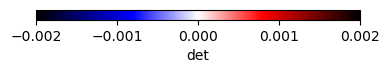

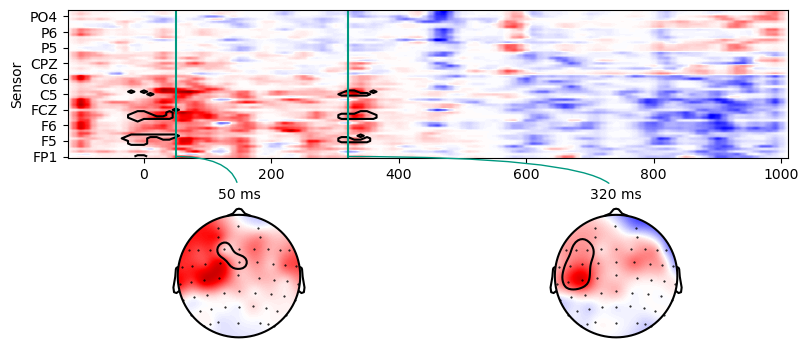

In [10]:
### For ESLs  ###
#subj = 2
"""
subject_nSTR_p = "n_S%.3d_ICAed_raw.fif" %subj

raw = mne.io.read_raw_fif(EEG_DIR / f'{subject_nSTR_p}', preload=True)

montage_x = eelbrain.load.fiff.sensor_dim(raw.info)
#temp_data = eeg_.T *1e+6
eeg_concatenated = eelbrain.NDVar(temp_data, (time, montage_x), name='EEG', info={'unit': 'µV'})

SUBJECTS = ['1', '2', '3', '4', '5', '6', '7']
rows = []
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle('Subj%s_TRFs_envelop_w_on.pickle'%(subject))
    rows.append([subject, trf.proportion_explained, trf.h[0].abs()])
    pass
data_env = eelbrain.Dataset.from_caselist(['subject', 'det', 'trf'], rows)
"""
subj_sLIST = [3, 4, 5, 6, 7, 8]
rowsLIST = []

# res.h[0] >> <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>

## TRFs Envelope  ##
for subj in  subj_sLIST:
    res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d envelope.pickle'%(subj, subj)))
    rowsLIST.append([subj, res.proportion_explained, res.h[0]])#.abs()])
data_env = eelbrain.Dataset.from_caselist(['subject', 'det', 'trf'], rowsLIST)
pprint(rowsLIST)
print(data_env)


#test that model predictive power on held-out data is > 0
test_envelope = eelbrain.testnd.TTestOneSample('det', ds=data_env, tail=1, pmin=0.1)
p = eelbrain.plot.Topomap(test_envelope)
cb = p.plot_colorbar(width=0.1)


# ## Envelope TRF
# Test the TRF with a one-sample *t*-test against 0. This tests the null-hypothesis that the electrical current direction at each time point was random across subjects. The systematic current directions shown below at anterior electrodes are typical of auditory responses. 

trf_envelope = eelbrain.testnd.TTestOneSample('trf', ds=data_env, pmin=0.1)

# gammatone >> ,t=[0.87]
# gammatone_onset >> ,t=[0.42, 0.52]
p = eelbrain.plot.TopoArray(trf_envelope, t=[0.05, 0.32], clip='circle', cmap='xpolar', h=4, w = 8) #, t=[0.08, 0.16, 0.22, 0.45]
cb = p.plot_colorbar(width=0.1)

p.save(TRF_DIR / 'ESLs_envelope-TRFs.png')

#x = trf的結果

In [11]:
## TRF: envelope+onset ##
subj_sLIST = [3, 4, 5, 6, 7, 8]
rowsLIST = []

for subj in  subj_sLIST:
    res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d envelope+onset.pickle'%(subj, subj)))
    rowsLIST.append([subj, res.proportion_explained, *res.h])#.abs()])
    x_names = res.x
data_onset = eelbrain.Dataset.from_caselist(['subject', 'det', *x_names], rowsLIST)
pprint(rowsLIST)
print(data_onset)

test_onset = eelbrain.testnd.TTestOneSample('det', ds=data_onset, tail=1, pmin=0.05)
# Paired t-test by specifying two measurement NDVars with matched cases
# Note that this presupposes that subjects are in the same order
test_onset_envelope = eelbrain.testnd.TTestRelated(data_onset['det'], data_env['det'], tail=1, pmin=0.05)
p2 = eelbrain.plot.Topomap(
    [test_onset.masked_difference(), test_onset_envelope.masked_difference()], 
    axtitle=[['Envelope + Onsets\n', test_onset], ['Envelope + Onsets > Envelope\n', test_onset_envelope]],
    ncol=2, clip='circle')
cb = p.plot_colorbar(width=0.1)

trf_eo_envelope = eelbrain.testnd.TTestOneSample('envelope', ds=data_onset, pmin=0.05)
trf_eo_onset = eelbrain.testnd.TTestOneSample('onset', ds=data_onset, pmin=0.05)


p2.save(TRF_DIR / 'ESLs_Envelope+onset-TRFs_topo.png')

[[3,
  <NDVar '1': 57 sensor>,
  <NDVar 'envelope': 57 sensor, 114 time>,
  <NDVar 'onset': 57 sensor, 114 time>],
 [4,
  <NDVar '1': 57 sensor>,
  <NDVar 'envelope': 57 sensor, 114 time>,
  <NDVar 'onset': 57 sensor, 114 time>],
 [5,
  <NDVar '1': 57 sensor>,
  <NDVar 'envelope': 57 sensor, 114 time>,
  <NDVar 'onset': 57 sensor, 114 time>],
 [6,
  <NDVar '1': 57 sensor>,
  <NDVar 'envelope': 57 sensor, 114 time>,
  <NDVar 'onset': 57 sensor, 114 time>],
 [7,
  <NDVar '1': 57 sensor>,
  <NDVar 'envelope': 57 sensor, 114 time>,
  <NDVar 'onset': 57 sensor, 114 time>],
 [8,
  <NDVar '1': 57 sensor>,
  <NDVar 'envelope': 57 sensor, 114 time>,
  <NDVar 'onset': 57 sensor, 114 time>]]
subject
-------
3      
4      
5      
6      
7      
8      
-------
NDVars: det, envelope, onset


[[3,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [4,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [5,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [6,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [7,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>],
 [8,
  <NDVar '1': 57 sensor>,
  <NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>]]
subject
-------
3      
4      
5      
6      
7      
8      
-------
NDVars: det, gammatone, gammatone_

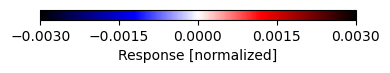

In [14]:
rowsLIST = []
x_names = None

for subj in  subj_sLIST:
    res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d acoustic.pickle'%(subj, subj)))
    rowsLIST.append([subj, res.proportion_explained, *res.h])#.abs()])
    x_names = res.x
data_acoustic = eelbrain.Dataset.from_caselist(['subject', 'det', *x_names], rowsLIST)
pprint(rowsLIST)
print(data_acoustic)

# Compare predictive power of the two models
test_acoustic = eelbrain.testnd.TTestOneSample('det', ds=data_acoustic, tail=1, pmin=0.05)
# Paired t-test by specifying two measurement NDVars with matched cases
# Note that this presupposes that subjects are in the same order
test_acoustic_onset = eelbrain.testnd.TTestRelated(data_acoustic['det'], data_onset['det'], tail=1, pmin=0.05)
p3 = eelbrain.plot.Topomap(
    [test_acoustic.masked_difference(), test_acoustic_onset.masked_difference()], 
    axtitle=[[['Spectrogram\n', test_acoustic], ], ['Spectrogram > Envelope\n', test_acoustic_onset]],
    ncol=2, clip='circle')
cb = p.plot_colorbar(width=0.1)

p3.save(TRF_DIR / 'ESLs_acoustic-TRFs_topo.png')

AttributeError: 'numpy.float64' object has no attribute 'smooth'

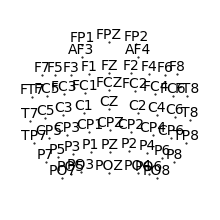

In [19]:
### LATER ANALYSIS  ###
# ## TRFs
# Since these spectrogram mTRFs have a frequency dimension in addition to time and sensor we have to slice or aggregate them for visualization on a 2d plot. We take two approaches: 
#
#  1) Sum across the frequency, based on the assumtopn that TRFs are similar for different frequency bands
#  2) Average across a group of neighboring sensors, to verify this assumtopn 

trf_spectrogram = eelbrain.testnd.TTestOneSample("gammatone.sum('frequency')", ds=data_acoustic, pmin=0.05)
trf_onset_spectrogram = eelbrain.testnd.TTestOneSample("gammatone_on.sum('frequency')", ds=data_acoustic, pmin=0.05)

#p4 = eelbrain.plot.TopoArray([trf_spectrogram, trf_onset_spectrogram], t=[0.050, 0.100, 0.150, 0.450], xlim=(-0.050, 0.950))

# Manually define sensors that are sensitive to acoustic responses 
#auditory_sensors = ['59', '20', '21', '7', '8', '9', '49', '19' ,'44', '45', '34' ,'35' ,'36' ,'10']
p5 = eelbrain.plot.SensorMap(data_acoustic['det'], h=2)

strf_spectrogram = data_acoustic['gammatone'].mean().smooth('frequency', window_samples=7, fix_edges=True)
strf_onset_spectrogram = data_acoustic['gammatone_on'].mean()
#p6 = eelbrain.plot.Array([strf_spectrogram, strf_onset_spectrogram], ncol=2, xlim=(-0.050, 0.950))


#p4.save(TRF_DIR / 'Natives_acoustic-TRFs_topo.png')
#p5.save(TRF_DIR / 'Natives_acoustic-TRFs_topo.png')
#p6.save(TRF_DIR / 'Natives_acoustic-TRFs_topo.png')

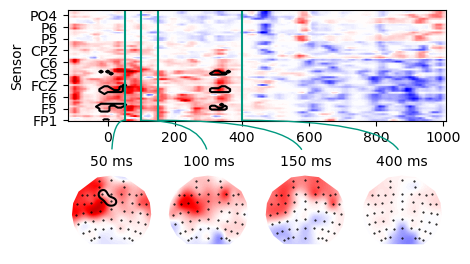

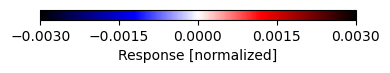

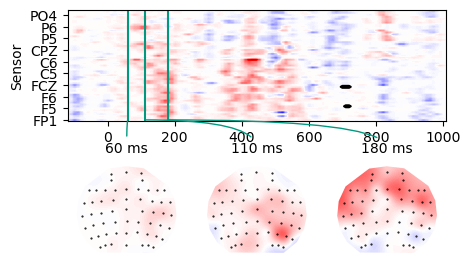

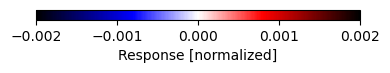

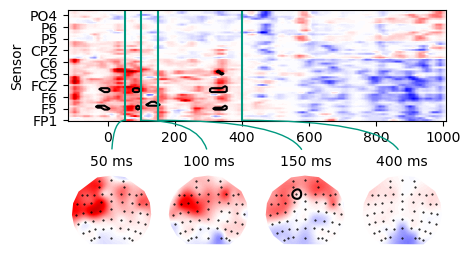

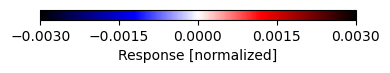

In [20]:
# Load cross-validated preditive power of all models
models = ['envelope', 'envelope+onset', 'acoustic']
rowsLIST = []

for model in models:
    for subj in  subj_sLIST:
        res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d %s.pickle'%(subj, subj, model)))
        rowsLIST.append([subj, model, res.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rowsLIST)
# For more interpretable numbers, express proportion explained in terms of the maximum explained variability by the full model
index = model_data['model'] == 'acoustic'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')

# Redo tests with adjusted predictive power 
test_envelope = eelbrain.testnd.TTestOneSample('det', sub="model == 'envelope'", ds=model_data, tail=1, pmin=0.05)
test_acoustic = eelbrain.testnd.TTestOneSample('det', sub="model == 'acoustic'", ds=model_data, tail=1, pmin=0.05)
test_onset_envelope = eelbrain.testnd.TTestRelated('det', 'model', 'envelope+onset', 'envelope', 'subject', ds=model_data, tail=1, pmin=0.05)
test_acoustic_onset = eelbrain.testnd.TTestRelated('det', 'model', 'acoustic', 'envelope+onset', 'subject', ds=model_data, tail=1, pmin=0.05)

t_envelope = [0.050, 0.150, 0.320, 0.400]
t_onset = [0.060, 0.110, 0.180]

#'Envelope TRF'
p7 = eelbrain.plot.TopoArray(trf_envelope, t=t_envelope) 
p7.plot_colorbar(width=0.1) #below=axes[1], **cbar_args, ticks=0, label='TRF (a.u.)')

#'Onset TRF' in envelope+onset
p8 = eelbrain.plot.TopoArray(trf_eo_onset, t=t_onset)
p8.plot_colorbar(width=0.1)
# 'Envelope TRF' in envelope+onset
p9 = eelbrain.plot.TopoArray(trf_eo_envelope, t=t_envelope)
p9.plot_colorbar(width=0.1)

"""
# 'Onset STRF (sum across frequency)'
p10 = eelbrain.plot.TopoArray(trf_onset_spectrogram, t=t_onset)
p10.plot_colorbar(width=0.1)
# 'Envelope STRF (sum across frequency)'
p11 = eelbrain.plot.TopoArray(trf_spectrogram, t=t_envelope)
p11.plot_colorbar(width=0.1)
"""


p7.save(TRF_DIR / 'ESLs_Envelope TRF_envelop.png')
p8.save(TRF_DIR / 'ESLs_Envelope+onset TRF_Onset TRF.png')
p9.save(TRF_DIR / 'ESLs_Envelope+onset TRF_Envelope TRF.png')
#p10.save(TRF_DIR / 'ESLs_Onset TRF_sum-of-freq.png')
#p11.save(TRF_DIR / 'ESLs_Envelope TRF_sum-of-freq.png')

## LATER  ##

In [20]:
subj = 3
#res = eelbrain.load.unpickle(TRF_DIR / Path('S%.3d/S%.3d acoustic.pickle'%(subj, subj)))
res.h

(<NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>,
 <NDVar 'gammatone_on': 57 sensor, 8 frequency, 114 time>)

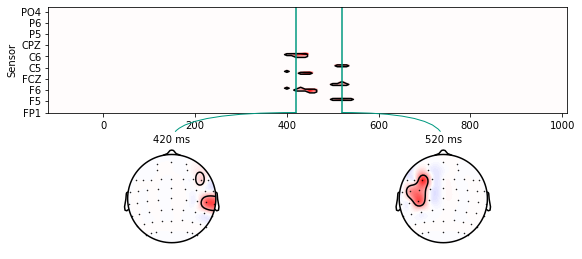

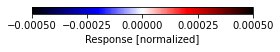

In [5]:
p = eelbrain.plot.TopoArray(trf_envelope,t=[0.42, 0.52], clip='circle', cmap='xpolar', h=4, w=8) #, t=[0.08, 0.16, 0.22, 0.45]
cb = p.plot_colorbar(width=0.1)

<NDVar 'gammatone': 57 sensor, 8 frequency, 114 time>


ValueError: y=<NDVar 'gammatone': 57 sensor, 8 frequency, 114 time> is ambiguous for required dimensions ('sensor', None)

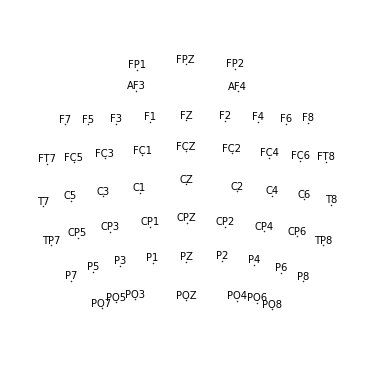

In [15]:

sensor = res.proportion_explained

sensor_plot = eelbrain.plot.SensorMap(res.h[0]) # plot all the channels
#topomap_plot = eelbrain.plot.Topomap(res.h[0], w=10, h=4)
print(res.h[0])


#p = eelbrain.plot.Topomap(res.h[0]('sensor',)) #,sensors=sensor, w=6, h=5)

#print(type(res.h[0]))
#timeINT = res.h[0].shape[2]
#print(type(time))
p = eelbrain.plot.TopoButterfly(res.h[0], w=10, h=4)
#p.set_time(.180)


In [23]:
temp_h0 = res.h[0]
dir(temp_h0)

['__abs__',
 '__add__',
 '__and__',
 '__array_interface__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',


In [29]:
temp_h0.frequency.values #==每個frequency band的mean

array([  72.16527455,  211.59617652,  415.61543108,  714.142197  ,
       1150.95503684, 1790.11198636, 2725.34458223, 4093.80347019])

In [31]:
temp_h0.x.sum(axis=1)  #依照axis=? (也就是矩陣的哪個axis)來計算 >> axis=1以band的來做

(57, 114)

In [32]:
temp_h0.x #.sum(axis=1)
# 重置回來的NDVar物件是要 NDVar(y, [montage, frequency(e.g. 256/8), time(UTS)], 'trf_name')
# Spectrogram by word class 那張圖，要看L2 & L1的族群比較>>後期分析要做

array([[[ 2.89120579e-20,  5.05961014e-20,  1.44560290e-20, ...,
          2.32142857e-04,  7.81250000e-05,  8.92857143e-06],
        [ 1.44560290e-20,  0.00000000e+00,  0.00000000e+00, ...,
          4.46428571e-04,  2.41071429e-04,  3.57142857e-05],
        [-1.44560290e-20,  7.22801448e-21,  3.43330688e-20, ...,
         -2.80085561e-20, -9.03501810e-21, -7.22801448e-21],
        ...,
        [ 2.16840434e-20,  0.00000000e+00, -7.22801448e-21, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.78241159e-20, -3.61400724e-20, -1.44560290e-20, ...,
          0.00000000e+00,  0.00000000e+00, -5.78241159e-20],
        [-2.89120579e-20, -1.80700362e-20, -1.44560290e-20, ...,
          5.78241159e-20,  2.89120579e-20,  9.39641883e-20]],

       [[-1.44560290e-20,  4.33680869e-20,  1.80700362e-20, ...,
          6.69642857e-04,  3.61607143e-04,  5.35714286e-05],
        [-8.92857143e-06, -6.02678571e-05, -1.11607143e-04, ...,
          2.05546662e-20, -5.10016177e